In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from keras import models
from keras.models import Model
from keras.layers import Input
import tensorflow
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape

In [4]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
# Same labels will be reused throughout the program
# LABELS = ['hot',
#           'cold']
# The number of steps within one time segment
TIME_PERIODS = 256
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 16

In [5]:
df = pd.read_csv("gdrive/MyDrive/HARDatasets/WISDM2011.csv")

In [6]:
df.head(5)

,user-id,activity,timestamp,ax,ay,az,AccMag_sub9_8
0,33,Jogging,49105962326000,-0.7,12.7,0.5,2.9
1,33,Jogging,49106062271000,5.0,11.3,1.0,2.6
2,33,Jogging,49106112167000,4.9,10.9,-0.1,2.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0,9.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2,4.3


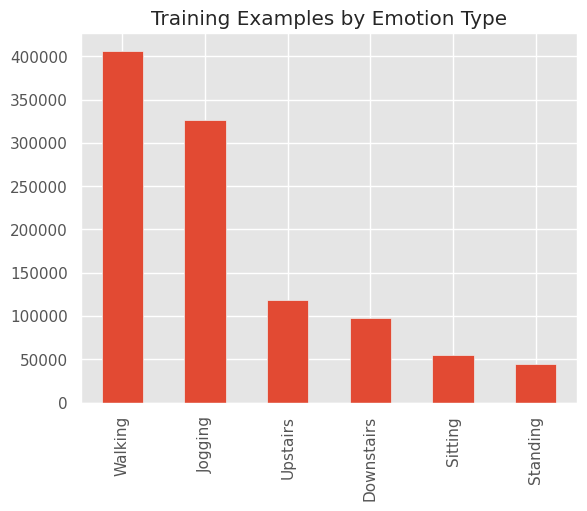

In [7]:
# Show how many training examples exist for each of the six activities
df['activity'].value_counts().plot(kind='bar', title='Training Examples by Emotion Type')
plt.show()

In [8]:
df['activity'].value_counts()

Walking       406775
Jogging       325975
Upstairs      118589
Downstairs     97813
Sitting        54876
Standing       44547
Name: activity, dtype: int64

In [9]:
# Define column name of the label vector
LABEL = 'activity'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   user-id        1048575 non-null  int64  
 1   activity       1048575 non-null  int64  
 2   timestamp      1048575 non-null  int64  
 3   ax             1048575 non-null  float64
 4   ay             1048575 non-null  float64
 5   az             1048575 non-null  float64
 6   AccMag_sub9_8  1048575 non-null  float64
dtypes: float64(4), int64(3)
memory usage: 56.0 MB


In [11]:
#df['MagAcc'] = df['MagAcc'] -   df['MagAcc'].mean() / df['MagAcc'].std()
df['AccMag_sub9_8'] = df['AccMag_sub9_8'] -  df['AccMag_sub9_8'].mean()  / df['AccMag_sub9_8'].std()

In [12]:
import numpy as np
import pandas as pd

def create_segments_and_labels(df, time_steps, step, label_name):
    # Number of features
    N_FEATURES = 1

    segments = []
    labels = []

    for i in range(0, len(df) - time_steps, step):
        # Extract segments for each axis
        segment_AccMag = df["AccMag_sub9_8"].values[i: i + time_steps]

        # Mode of labels within the segment
        label = df[label_name][i: i + time_steps].mode()[0]

        # Append segment and label
        segments.append([segment_AccMag])
        labels.append(label)

    # Reshape segments
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels


# Example usage
x_data, y_data  = create_segments_and_labels(df,
                                                                 TIME_PERIODS,
                                                                 STEP_DISTANCE,
                                                                 LABEL)


print (x_data.shape)
print(y_data.shape)

(65520, 256, 1)
(65520,)


In [13]:
#deviding dataset into 70 % (train) and 30% test chuncks
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(45864, 256, 1) (45864,)
(19656, 256, 1) (19656,)


In [14]:
# Set input & output dimensions
num_time_periods, num_sensors = X_train.shape[1], X_train.shape[2]
num_classes = le.classes_.size
labels=list(le.classes_)
print(list(le.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [15]:
# Printing shapes
print('X_train shape: ', X_train.shape)
print(X_train.shape[0], 'training samples')

# One-hot encode labels
y_train = np.eye(num_classes)[y_train]
print('y_train shape: ', y_train.shape)

X_train shape:  (45864, 256, 1)
45864 training samples
y_train shape:  (45864, 6)


In [16]:
# Printing shapes
print('X_test shape: ', X_test.shape)
print(X_train.shape[0], 'training samples')

# One-hot encode labels
y_test = np.eye(num_classes)[y_test]
print('y_train shape: ', y_test.shape)

X_test shape:  (19656, 256, 1)
45864 training samples
y_train shape:  (19656, 6)


#Deep Leanring Model

In [17]:
from keras import models
from keras.models import Model
from keras.layers import Input
import tensorflow
# cnn model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras.layers   import Conv1D
from tensorflow.keras.layers   import MaxPooling1D
from tensorflow.keras.layers import Add

from keras import models
from keras.models import Model
from keras.layers import Input
from keras.layers import add
from keras.layers import Activation
from keras.layers import GRU
from keras.layers import LSTM, Bidirectional, BatchNormalization

In [23]:
from keras import models
from keras.models import Model
from keras.layers import Input,concatenate

In [19]:
from keras.layers import add
from keras.layers import Activation

In [20]:
from keras.layers import Dense, Dropout
from keras.layers import GRU, Bidirectional, TimeDistributed, Activation, LSTM, add,BatchNormalization, GlobalAveragePooling1D

In [28]:

def create_model(trainX, trainy):
  n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
  input_shape=(n_timesteps,n_features)
  signal_input = Input(shape=input_shape, name='data')

#<---------------------------------------------module 1 starts---------------------------------------->

  layer_1_Just = Conv1D(filters=10,  kernel_size=1, padding='same', activation='relu')(signal_input) #with 1x1 conv

  layer_1_a = MaxPooling1D(pool_size=1, padding='same')(signal_input) # pooling
  layer_Max_a = Conv1D(10,  kernel_size=1, padding='same', activation='relu')(layer_1_a) # with 1x1

  layer_1_a = Conv1D(filters=10,  kernel_size=1, padding='same', activation='relu')(signal_input) #with 1x1 conv
  layer_1_a = Conv1D(filters=10,  kernel_size=3, padding='same', activation='relu')(layer_1_a) # with 1x3

  layer_2_a = Conv1D(10,  kernel_size=1, padding='same', activation='relu')(signal_input) #with 1x1
  layer_2_a = Conv1D(10,  kernel_size=5, padding='same', activation='relu')(layer_2_a)#with 1x5

  layer_3_a = Conv1D(10,  kernel_size=1, padding='same', activation='relu')(signal_input) #with 1x1
  layer_3_a = Conv1D(10,  kernel_size=7, padding='same', activation='relu')(layer_3_a) #with 1x7

  layer_4_a = Conv1D(10,  kernel_size=1, padding='same', activation='relu')(signal_input) #with 1x1
  layer_4_a = Conv1D(10,  kernel_size=9, padding='same', activation='relu')(layer_4_a) #with 1x9

  mid_1_a = concatenate([layer_Max_a,layer_1_Just,layer_1_a, layer_2_a,layer_3_a,layer_4_a], axis = 2)
  mid_1_a=Conv1D(filters=64,  kernel_size=1, padding='same', activation='relu')(mid_1_a)

  input2SameDie=Conv1D(filters=64,  kernel_size=1, padding='same', activation='relu')(signal_input)
  after_addition1=add([mid_1_a,input2SameDie])
  drop0=Dropout(0.25)(after_addition1)
  bn1=BatchNormalization()(drop0)
#<----------------------------------------------module 1 ends here----------------------------->

#<----------------------------------------------module 2 starts---------------------------------------->

  layer_2_Just = Conv1D(filters=10,  kernel_size=1, padding='same', activation='relu')(bn1) #with 1x1 conv

  layer_2_a = MaxPooling1D(pool_size=1, padding='same')(bn1) # pooling
  layer_Max_a_2 = Conv1D(10,  kernel_size=1, padding='same', activation='relu')(layer_2_a) # with 1x1

  layer_1_a = Conv1D(filters=10,  kernel_size=1, padding='same', activation='relu')(bn1) #with 1x1 conv
  layer_1_a = Conv1D(filters=10,  kernel_size=3, padding='same', activation='relu',name='1x3_a')(layer_1_a) # with 1x3

  layer_2_a = Conv1D(10,  kernel_size=1, padding='same', activation='relu')(bn1) #with 1x1
  layer_2_a = Conv1D(10,  kernel_size=5, padding='same', activation='relu')(layer_2_a)#with 1x5

  layer_3_a = Conv1D(10,  kernel_size=1, padding='same', activation='relu')(bn1) #with 1x1
  layer_3_a = Conv1D(10,  kernel_size=7, padding='same', activation='relu')(layer_3_a) #with 1x7

  layer_4_a = Conv1D(10,  kernel_size=1, padding='same', activation='relu')(bn1) #with 1x1
  layer_4_a = Conv1D(10,  kernel_size=9, padding='same', activation='relu')(layer_3_a) #with 1x7

  mid_1_a = concatenate([layer_Max_a_2,layer_2_Just,layer_1_a, layer_2_a,layer_3_a,layer_4_a], axis = 2)
  mid_1_a=Conv1D(filters=64,  kernel_size=1, padding='same', activation='relu')(mid_1_a)

  input2SameDie=Conv1D(filters=64,  kernel_size=1, padding='same', activation='relu')(after_addition1)
  after_addition2=add([mid_1_a,input2SameDie])
  drop1=Dropout(0.25)(after_addition2)
  bn2=BatchNormalization()(drop1)

#<----------------------------------------------module 2 ends here---------------------------------------->

  ShapeSameRawInput=Conv1D(filters=64,  kernel_size=1, padding='same', activation='relu')(signal_input)
  FeaturesCon= concatenate([ShapeSameRawInput,bn2], axis = 2)

#-----------------------------------------Dense link----------------------------------------------------->

#<==//-//-//-//-//-//-//-//- CNN feature extraction Completed//-//-//-//-//-//-//-//-//-//==>

  rnn1=Bidirectional(GRU(128))(FeaturesCon) # GRU with 128 neurons
  bn3=BatchNormalization()(rnn1)

#<==//-//-//-//-//-//-//-//- RNN feature extraction Completed//-//-//-//-//-//-//-//-//-//==>

  flat_1 = Flatten()(bn3) # Flatting
  drop3=Dropout(0.25)(flat_1)

  dense_1 = Dense(512, activation='relu')(drop3)#Fully Connected
  drop4=Dropout(0.25)(dense_1)

  out = Dense(n_outputs, activation='softmax', name='predictions')(drop4) # Prediction

  rez = Model(inputs=signal_input, outputs=out)
  return rez

In [29]:
model=create_model(X_train, y_train)

In [30]:
print (model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, 256, 1)]             0         []                            
                                                                                                  
 max_pooling1d_3 (MaxPoolin  (None, 256, 1)               0         ['data[0][0]']                
 g1D)                                                                                             
                                                                                                  
 conv1d_32 (Conv1D)          (None, 256, 10)              20        ['data[0][0]']                
                                                                                                  
 conv1d_34 (Conv1D)          (None, 256, 10)              20        ['data[0][0]']            

In [31]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [32]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1)

In [33]:
verbose, epochs, batch_size = 0, 90, 120
history=model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)#,callbacks=[es])

Epoch 1/90
383/383 [==============================] - 52s 73ms/step - loss: 0.4908 - accuracy: 0.8023 - val_loss: 0.3065 - val_accuracy: 0.8654
Epoch 2/90
383/383 [==============================] - 21s 56ms/step - loss: 0.1781 - accuracy: 0.9221 - val_loss: 0.1602 - val_accuracy: 0.9298
Epoch 3/90
383/383 [==============================] - 21s 54ms/step - loss: 0.1333 - accuracy: 0.9427 - val_loss: 0.1418 - val_accuracy: 0.9417
Epoch 4/90
383/383 [==============================] - 20s 52ms/step - loss: 0.1202 - accuracy: 0.9479 - val_loss: 0.1030 - val_accuracy: 0.9555
Epoch 5/90
383/383 [==============================] - 22s 58ms/step - loss: 0.1046 - accuracy: 0.9551 - val_loss: 0.1243 - val_accuracy: 0.9513
Epoch 6/90
383/383 [==============================] - 21s 54ms/step - loss: 0.1001 - accuracy: 0.9557 - val_loss: 0.1434 - val_accuracy: 0.9491
Epoch 7/90
383/383 [==============================] - 20s 52ms/step - loss: 0.0941 - accuracy: 0.9593 - val_loss: 0.0894 - val_accuracy:

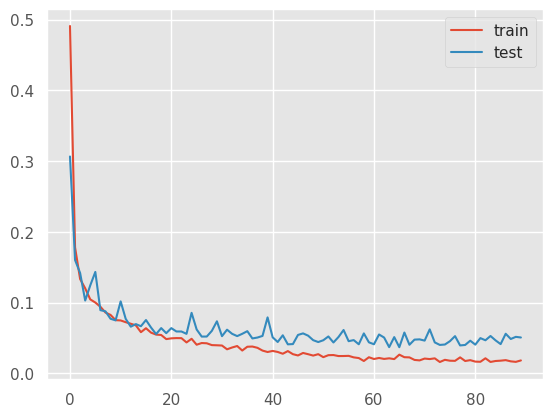

In [34]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

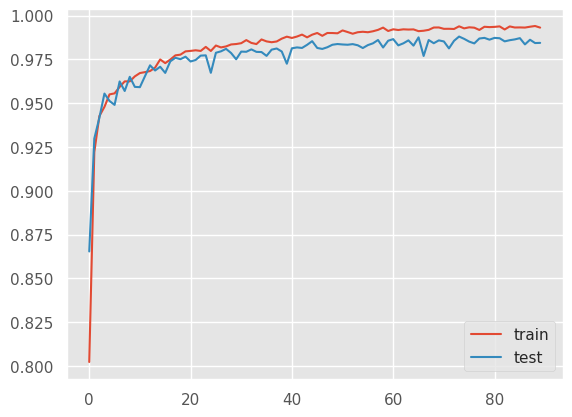

In [35]:
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [36]:
_, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print ("accuracy = ",accuracy*100)

accuracy =  98.44831228256226


In [37]:
_, accuracy = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
print ("accuracy = ",accuracy*100)

accuracy =  99.36551451683044


# Confusion Matrix

In [38]:
labels=['sad',
          'disgust',
          'fear',
          'happy',
          'surprise',
          'anger']

In [39]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# create a confusion matrix to visually represent incorrectly classified images
def plot_confusion_matrix(y_true, y_pred, classes, out_path=""):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
    plt.figure(figsize=(6, 6))
    ax = sn.heatmap(df_cm, annot=True, square=True, fmt="d", linewidths=.2 ,cbar_kws={"shrink": 0.8})
    return ax

615/615 [==============================] - 8s 11ms/step


<Axes: >

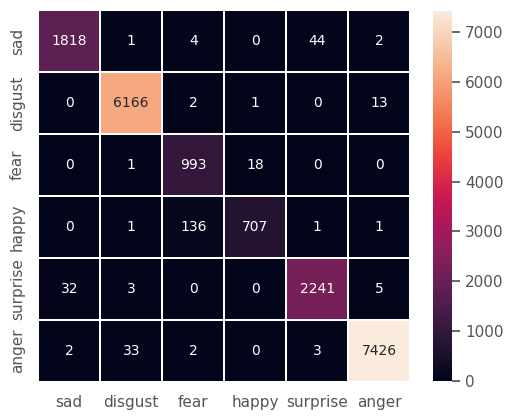

In [40]:
y_pred=model.predict(X_test)
plot_confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1),labels)

615/615 [==============================] - 6s 9ms/step


<Axes: >

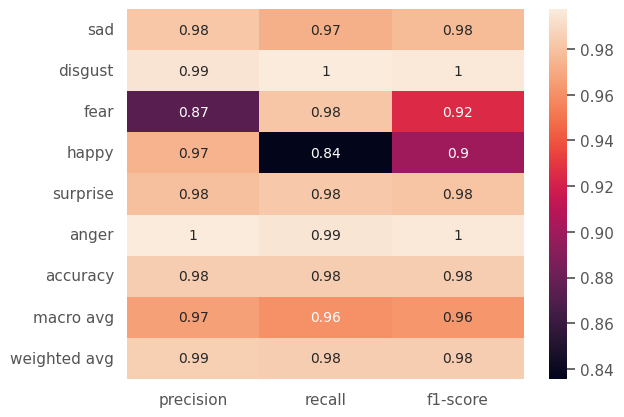

In [41]:
from sklearn.metrics import classification_report
import seaborn as sns
y_pred=model.predict(X_test)
report= classification_report(y_test.argmax(axis=1),y_pred.argmax(axis=1),target_names=labels,output_dict=True)
#print (report)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)

In [42]:
model.save("1DAccTrained_WISDM2011.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
